In [1]:
import os
import sqlite3
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None 


In [2]:
db_path = os.path.abspath('')
db_path = "\\".join(db_path.split("\\")[0:-1]) + "\\steam_stats.db"
conn = sqlite3.connect(db_path)


steam_stats_q = """select 
	A.*,
	B.twitch_game_id,
	C.release_date,
	C.num_dlcs,
	C.num_expansions
from steam_stats A
left join steam_twitch_mapping B on A.game = B.steam_game
left join twitch_game_info C on B.twitch_game_id = C.twitch_id"""

steam_stats = pd.read_sql_query(steam_stats_q,conn,parse_dates=["refresh_date","release_date"])
steam_stats["twitch_game_id"] = steam_stats["twitch_game_id"].astype("Int64")

developers_q = """select A.twitch_id,B.company_name
from twitch_game_involved_companies A 
left join twitch_companies B on A.company_id = B.company_id
where A.role = 'developer' """

developers = pd.read_sql_query(developers_q,conn)

genres_q = """select A.twitch_id,B.genre_name
from twitch_game_genres A
left join twitch_genres B on A.genre_id = B.genre_id"""

genres = pd.read_sql_query(genres_q,conn)

print(steam_stats[["current_players","peak_today"]].describe())
steam_stats["game"].nunique()

       current_players     peak_today
count       6100.00000    6100.000000
mean       43083.76082   58316.765082
std        89055.27950  119669.269467
min         5757.00000    7432.000000
25%        12005.00000   17079.000000
50%        19192.00000   26120.000000
75%        34268.00000   42696.000000
max       928329.00000  928329.000000


126

## Top 10 games based on max daily peak

In [3]:
df = steam_stats.groupby("game").agg(
    count = ("peak_today","count"),
    max_peak = ("peak_today","max"),
    avg_current_players = ("current_players","mean"),
    release_date = ("release_date","max")
)
df["avg_current_players"] = df["avg_current_players"].round(0).astype("Int64")
df_top10 = df.sort_values("max_peak",ascending=False).head(10)
df_top10

,count,max_peak,avg_current_players,release_date
game,,,,
Counter-Strike: Global Offensive,61,928329,647998,2012-08-21
Dota 2,61,661139,467876,2013-07-09
PUBG: BATTLEGROUNDS,61,378838,211480,2017-12-20
Lost Ark,61,352852,300497,2018-12-04
Apex Legends,61,344142,205545,2019-02-04
Grand Theft Auto V,61,197912,140503,2013-09-17
MultiVersus,61,153433,96379,2022-07-19
Team Fortress 2,61,123221,102327,2007-10-09
MONSTER HUNTER RISE,61,106135,57954,2022-06-30


In [4]:
max = int(((df_top10["max_peak"].max()/1000)+50).round(0))
x_ticks = range(0,max,100)
x_labels = [str(t) + "k" for t in x_ticks]


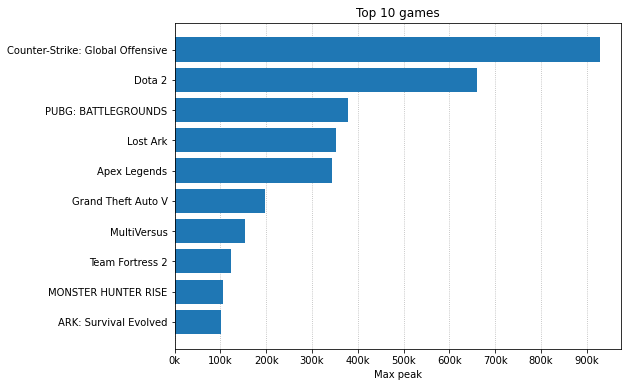

In [5]:
plt.figure(figsize=(8,6))
plt.title("Top 10 games")
plt.barh(df_top10.index.values,df_top10["max_peak"]/1000,zorder =2)
plt.gca().invert_yaxis()
plt.xlabel("Max peak")
plt.xticks(x_ticks,labels=x_labels)
plt.grid(axis = "x",linestyle = "dotted")
plt.show()

## Games age

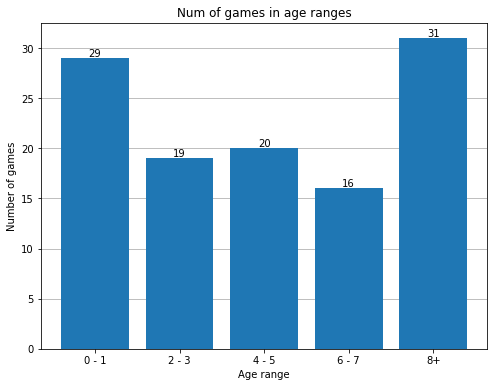

In [6]:
def age_group(age):
    if  age <2:
        return "0 - 1"
    elif age >= 2 and age < 4:
        return "2 - 3"
    elif age>=4 and age < 6:
        return "4 - 5"
    elif age>=6 and age < 8:
        return "6 - 7"
    return "8+" 

current_year = datetime.date.today().year
df = steam_stats[steam_stats["release_date"].notna()][["game","peak_today","release_date"]]
df["age"] = (pd.to_datetime('today') - df["release_date"]) / np.timedelta64(1, 'Y')
df["age_group"] = df["age"].map(age_group)
df_age = df.groupby("age_group").agg(
    num_of_games = ("game","nunique")
)

plt.figure(figsize=(8,6))
plt.title("Num of games in age ranges")
plt.ylabel("Number of games")
plt.xlabel("Age range")
b = plt.bar(df_age.index.values,df_age["num_of_games"],zorder = 2)
plt.bar_label(b,df_age["num_of_games"])
plt.grid(axis="y")
plt.show()


### Boxplot for max_peak in age groups

age_group
0 - 1    24623.0
2 - 3    19818.0
4 - 5    23710.0
6 - 7    19429.0
8+       26677.0
Name: peak_today, dtype: float64


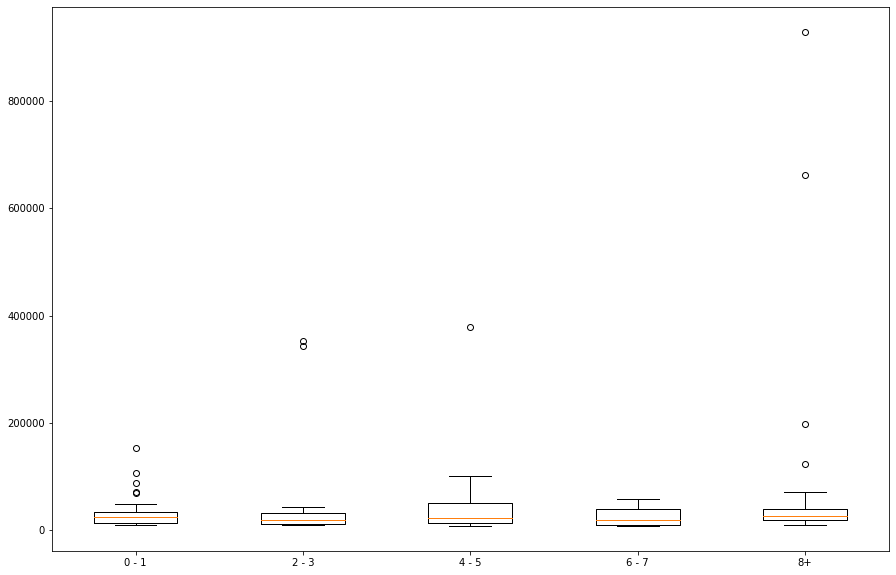

In [7]:
#top2 = df_top10.index.values.tolist()[0:2]
#df2 =df[~df["game"].isin(top2)]

df_peaks = df.groupby(["age_group","game"])["peak_today"].max()
df_peaks = df_peaks.droplevel(level=1)
print(df_peaks.groupby("age_group").median())
groups = df_peaks.index.unique().tolist()
groups
data = [df_peaks.loc[g].values.tolist() for g in groups]
plt.figure(figsize=(15,10))
plt.style.use('default')
plt.boxplot(data,labels=groups)
plt.show()


## Top 10 developers

In [8]:
steam_stats[steam_stats.twitch_game_id.notna()]
#developers.info()

df = pd.merge(steam_stats[steam_stats.twitch_game_id.notna()],developers,how = "left", left_on="twitch_game_id", right_on="twitch_id")
df_devs = df.groupby(["company_name","game"],as_index = False)["peak_today"].max()
df_devs_agg = df_devs.groupby("company_name").agg(
    count_games = ("game","count"),
    sum_max_peaks = ("peak_today","sum")
)

print(df_devs[df_devs.company_name == df_devs_agg.sort_values("sum_max_peaks",ascending=False).head(1).index.values[0]])
df_devs_agg.sort_values("sum_max_peaks",ascending=False).head(10)


          company_name                              game  peak_today
108  Valve Corporation                    Counter-Strike       13603
109  Valve Corporation  Counter-Strike: Global Offensive      928329
110  Valve Corporation                            Dota 2      661139
111  Valve Corporation                     Left 4 Dead 2       34803
112  Valve Corporation                          Spacewar       28937
113  Valve Corporation                   Team Fortress 2      123221


,count_games,sum_max_peaks
company_name,,
Valve Corporation,6,1790032
Hidden Path Entertainment,1,928329
PUBG Corp,1,378838
Tripod Studio,1,352852
Respawn Entertainment,1,344142
Rockstar North,1,197912
Player First Games,1,153433
Facepunch Studios,2,141899
Paradox Development Studio,4,108085


## Genres popularity

In [59]:
genres
ss = steam_stats.groupby(["game","refresh_date"],as_index=False).agg(
    max_peak = ("peak_today","max"),
    twitch_id = ("twitch_game_id","max")
)
ss = ss.groupby("game",as_index=False).agg(
    avg_max_peak = ("max_peak","max"),
    twitch_id = ("twitch_id","max")
)

df  = pd.merge(ss.dropna(),genres,how="left",left_on="twitch_id",right_on = "twitch_id")
df



,game,avg_max_peak,twitch_id,genre_name
0,7 Days to Die,30558,5574,Shooter
1,7 Days to Die,30558,5574,Role-playing (RPG)
2,7 Days to Die,30558,5574,Simulator
3,7 Days to Die,30558,5574,Strategy
4,7 Days to Die,30558,5574,Adventure
...,...,...,...,...
316,tModLoader,34466,1879,Indie
317,鬼谷八荒 Tale of Immortal,11754,143166,Role-playing (RPG)
318,鬼谷八荒 Tale of Immortal,11754,143166,Simulator
319,鬼谷八荒 Tale of Immortal,11754,143166,Adventure


### Top 10 genres based on numer of games in steam stats

                          num_of_games
genre_name                            
Adventure                           48
Simulator                           45
Indie                               43
Role-playing (RPG)                  41
Shooter                             37
Strategy                            34
Tactical                            10
Real Time Strategy (RTS)             9
Sport                                9
Platform                             8


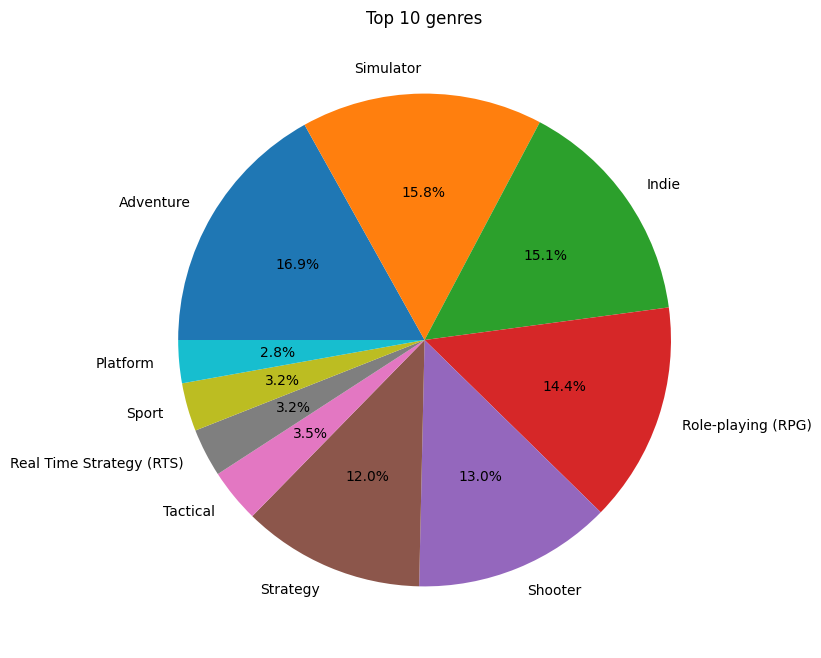

In [60]:
df_genre = df.groupby("genre_name").agg(
    num_of_games = ("game","nunique")
).nlargest(10,columns="num_of_games")
print(df_genre)
plt.figure(figsize = (8,8))
plt.title("Top 10 genres")
plt.pie(df_genre.num_of_games,labels=df_genre.index.values,autopct="%1.1f%%",startangle=180,counterclock=False)
plt.show()

### Top 3 games in each genre

In [87]:
df["genre_name"].unique().tolist()
l = []
for g in df["genre_name"].unique().tolist():
    df3 = df[df["genre_name"] == g][["genre_name","game","avg_max_peak"]].nlargest(n=3,columns = "avg_max_peak")
    l.append(df3)
df_g3 = pd.concat(l)
df_g3

,genre_name,game,avg_max_peak
52,Shooter,Counter-Strike: Global Offensive,928329
186,Shooter,PUBG: BATTLEGROUNDS,378838
16,Shooter,Apex Legends,344142
150,Role-playing (RPG),Lost Ark,352852
7,Role-playing (RPG),ARK: Survival Evolved,100924
216,Role-playing (RPG),Rust,98347
8,Simulator,ARK: Survival Evolved,100924
118,Simulator,Football Manager 2022,70653
100,Simulator,FIFA 22,70074
82,Strategy,Dota 2,661139
